# e23 Terrain Graph 2 Analysis

This notebook fetches runs from wandb tagged with `e23TG_neurogf_terrain_graph_2` and creates analysis plots.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import wandb_buddy as wb

---

# Setup and Configuration

## Notebook Parameters

Configuration for data fetching and analysis.

In [ ]:
# Fetch runs with the specified tag
TAG = "e23TG_neurogf_terrain_graph_2"
ENTITY = "alelab"
PROJECT = "terrains"

# Use test_mae (computed from history) as the error metric
ERROR_COL = 'test_mae'
ERROR_LABEL = 'Test MAE'

## Fetch Runs from Wandb by Tag

Retrieves all experiment runs tagged with `e23TG_neurogf_terrain_graph_2` from the Weights & Biases platform.


In [ ]:


print(f"Fetching runs with tag: {TAG}")
df = wb.load_runs(ENTITY, PROJECT, tags=[TAG])
print(f"Found {len(df)} runs")

In [ ]:
df.head()

In [ ]:
# Check available columns
print("Available columns:")
print(df.columns.tolist())

In [ ]:
# Extract resolution from dataset_name
def extract_resolution(row):
    dataset_name = str(row['dataset_name'])
    res_match = re.search(r'res(\d+)', dataset_name)
    return int(res_match.group(1))

df['resolution'] = df.apply(extract_resolution, axis=1)
print(f"Runs with valid resolution: {len(df)}")

In [ ]:
# Add density column (inverse of resolution squared)
df['density'] = 1 / (df['resolution'] ** 2)

print(f"Total runs: {len(df)}")
print(f"\nRuns by layer type:")
print(df['layer_type'].value_counts())
print(f"\nResolutions available:")
print(sorted(df['resolution'].unique()))

## Compute Test MAE from Batch History

**Problem**: The training script logs `test_batch_mae` for each batch during evaluation, but wandb only captures the last value in the run summary.

**Solution**: Fetch the full metric history from wandb and compute the average across all test batches.

**Why this matters:**
1. `test_mae` (summary metric) is only available for runs that completed all epochs
2. `test_batch_mae` in summary contains only the last batch's value
3. Averaging over all batches gives the true test MAE for all runs

This ensures we have complete and accurate performance metrics for all experiments.

In [ ]:
import wandb

def get_metric_history_mean(entity: str, project: str, run_id: str, metric: str) -> float:
    """
    Fetch the full history of a metric from a wandb run and return its mean.
    
    Args:
        entity: wandb entity/team name
        project: wandb project name  
        run_id: the run ID
        metric: name of the metric to fetch (e.g., 'test_batch_mae')
    
    Returns:
        Mean of all logged values for the metric, or NaN if no values exist
    """
    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")
    history = run.history(keys=[metric], pandas=True)
    
    if history.empty or metric not in history.columns:
        return np.nan
    
    values = history[metric].dropna()
    if len(values) == 0:
        return np.nan
    
    return values.mean()


def add_metric_from_history(df: pd.DataFrame, entity: str, project: str, 
                            source_metric: str, target_col: str) -> pd.DataFrame:
    """
    Add a new column to df by fetching metric history from wandb and computing the mean.
    
    Args:
        df: DataFrame with 'id' column containing wandb run IDs
        entity: wandb entity name
        project: wandb project name
        source_metric: metric name to fetch from history (e.g., 'test_batch_mae')
        target_col: name of the new column to add (e.g., 'test_mae_from_history')
    
    Returns:
        DataFrame with new column added
    """
    from tqdm import tqdm
    
    means = []
    for run_id in tqdm(df['id'], desc=f"Fetching {source_metric} history"):
        mean_val = get_metric_history_mean(entity, project, run_id, source_metric)
        means.append(mean_val)
    
    df[target_col] = means
    return df

In [ ]:
# Fetch test_batch_mae history and compute mean for each run
df = add_metric_from_history(df, ENTITY, PROJECT, 'test_batch_mae', 'test_mae')

print(f"Runs with valid test_mae (from history): {df['test_mae'].notna().sum()} / {len(df)}")
print(f"\nBy layer_type:")
print(df.groupby('layer_type')['test_mae'].apply(lambda x: f"{x.notna().sum()}/{len(x)} valid"))

In [ ]:
# Fetch test_batch_nmae history and compute mean for each run (Normalized MAE)
df = add_metric_from_history(df, ENTITY, PROJECT, 'test_batch_nmae', 'test_nmae')

print(f"Runs with valid test_nmae (from history): {df['test_nmae'].notna().sum()} / {len(df)}")
print(f"\nBy layer_type:")
print(df.groupby('layer_type')['test_nmae'].apply(lambda x: f"{x.notna().sum()}/{len(x)} valid"))

In [ ]:
df[['id','created_at','state','resolution','density','layer_type','test_batch_mae','test_mae']].head(25).sort_values('created_at', ascending=True)

In [ ]:
df[df.layer_type=='TAGConv'].train_resolution

In [ ]:


# Check how many runs have valid test_mae values
print(f"Runs with valid {ERROR_COL}: {df[ERROR_COL].notna().sum()} / {len(df)}")
print(f"\nBy layer_type:")
print(df.groupby('layer_type')[ERROR_COL].apply(lambda x: f"{x.notna().sum()}/{len(x)} valid"))

print("\nSample data:")
#df[['name', 'layer_type', 'resolution', 'density', 'stage', ERROR_COL]].head(10)
df[['name', 'layer_type', 'resolution', 'density', ERROR_COL]].head(10)

In [ ]:
# Check all test-related columns and their coverage
test_cols = [c for c in df.columns if 'test' in c.lower()]
print("Test metric coverage by layer_type:\n")
for col in test_cols:
    valid_counts = df.groupby('layer_type')[col].apply(lambda x: x.notna().sum())
    total_counts = df.groupby('layer_type').size()
    print(f"{col}:")
    for lt in valid_counts.index:
        print(f"  {lt}: {valid_counts[lt]}/{total_counts[lt]}")
    print()

In [ ]:
df.sort_values('resolution', ascending=False)[['name', 'layer_type', 'resolution', 'density', ERROR_COL]]

---

# Performance Analysis

This section analyzes model performance across different resolutions and graph sizes.

## 1. Scatter Plot: Performance vs Density

Visualizes the relationship between graph density (1/resolution²) and test error for all runs.


In [ ]:
# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.2)

df_plot = df

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='density',
    y=ERROR_COL,
    hue='layer_type',
    s=100,
    alpha=0.8,
    ax=ax
)

ax.set_xlabel('Density (1/resolution²)')
ax.set_ylabel(ERROR_LABEL)
ax.set_title(f'e23 Terrain Graph 2 -  Performance by Density')
ax.legend(title='Layer Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 2. Scaling Analysis: Performance vs Graph Size

This plot shows how model performance scales with the number of nodes in the terrain graph. The x-axis uses a log scale to better visualize the wide range of graph sizes (from 2,500 to 4,000,000 nodes).

**Key insights:**
- Shows best performance per resolution for each model
- Helps understand computational efficiency and scalability
- Exported as publication-quality figure

/tmp/ipykernel_1188867/2703005226.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['num_nodes'] = df_valid['resolution'].apply(


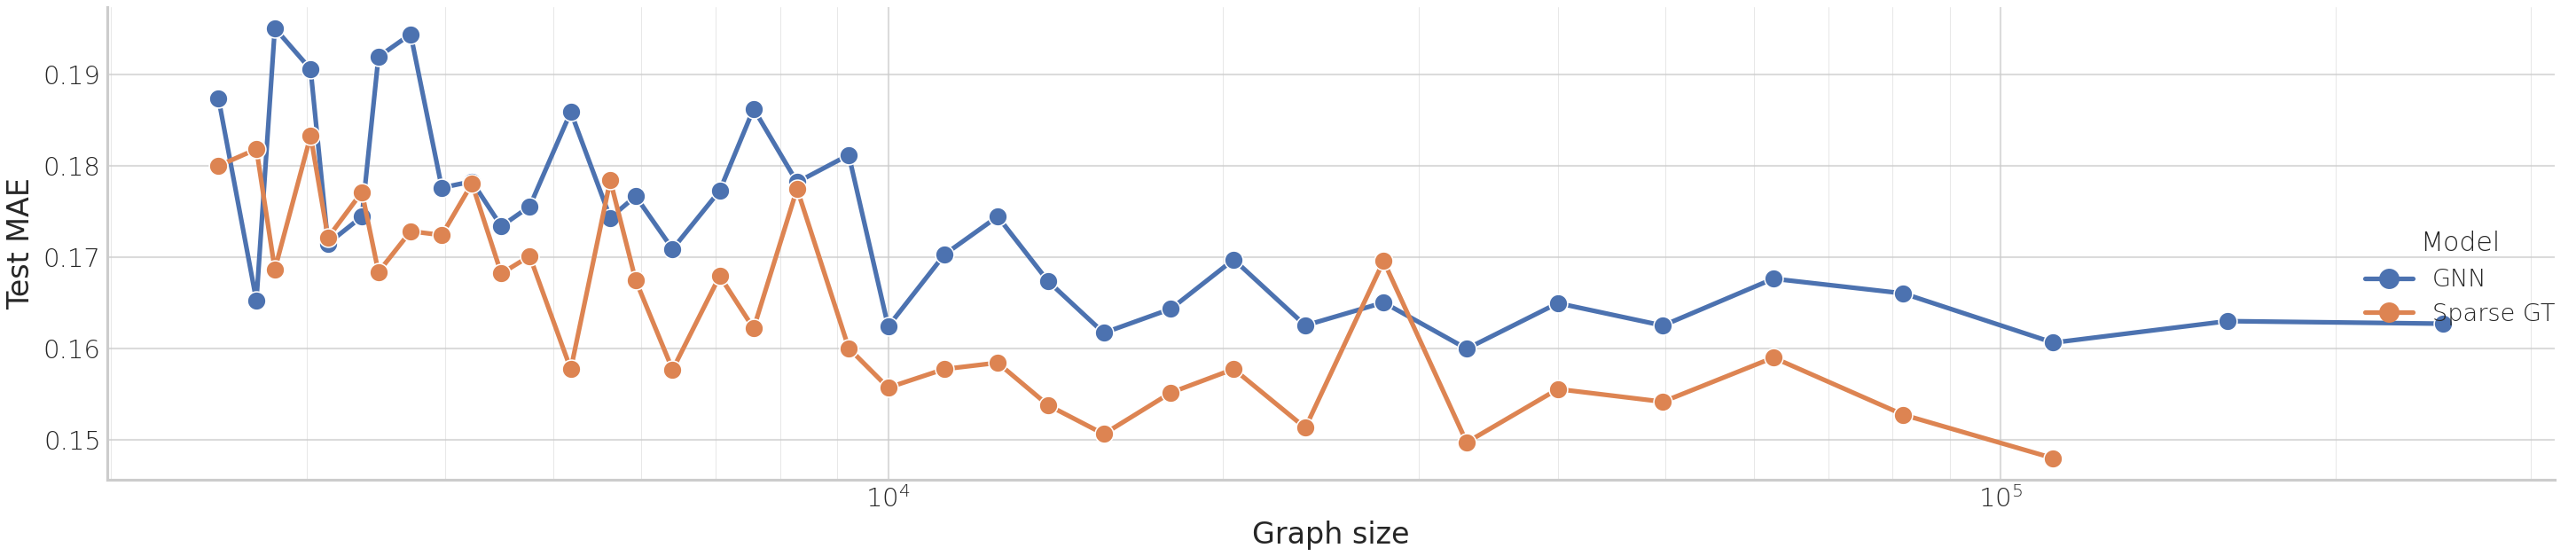

In [74]:
# Best performance per resolution per layer_type
# Filter out rows with NaN in ERROR_COL before groupby to avoid KeyError
df_valid = df.dropna(subset=[ERROR_COL])

# Compute num_nodes from resolution (Norway 2000x2000 terrain)
ORIGINAL_DIM = 2000
df_valid['num_nodes'] = df_valid['resolution'].apply(
    lambda r: ((ORIGINAL_DIM - 1) // r + 1) ** 2
)

best_per_resolution = df_valid.loc[df_valid.groupby(['layer_type', 'resolution'])[ERROR_COL].idxmin()]

# Paper-quality styling
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Lato', 'DejaVu Sans', 'Helvetica', 'Arial'],
    'font.weight': 'light',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.linewidth': 1.5,
    'legend.fontsize': 13,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'lines.linewidth': 2.5,
    'lines.markersize': 10,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})

# Label mapping for paper
LABEL_MAP = {'TAGConv': 'GNN', 'SparseGT': 'Sparse GT'}

# Prepare data with renamed labels
df_plot = best_per_resolution.copy()
df_plot['Model'] = df_plot['layer_type'].map(LABEL_MAP)

# Performance by num_nodes (BEST runs only - paper figure)
g = sns.relplot(
    data=df_plot.sort_values("Model", ascending=True),
    x='num_nodes',
    y=ERROR_COL,
    hue='Model',
    kind='line',
    marker='o',
    height=4.5,
    aspect=4
)

g.set_axis_labels('Graph size', ERROR_LABEL)
g.legend.set_title('Model')
g.ax.set_xscale('log')  # Log scale for better visualization

# Add minor gridlines for better granularity
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
g.ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=100))
g.ax.grid(True, which='major', alpha=0.7, linewidth=1.0)
g.ax.grid(True, which='minor', alpha=0.45, linewidth=0.5)

g.savefig('figures/norway_transferability.pdf', bbox_inches='tight', dpi=300)
g.savefig('figures/norway_transferability.png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

## 3. Transferability Plot: Performance vs Resolution

This is the main transferability figure showing how models trained at different resolutions perform. Lower resolution numbers indicate denser graphs with more nodes.

**Figure export:**
- Saved to `figures/norway_transferability.pdf` and `.png`
- Paper-quality formatting with proper fonts and styling
- Shows best run per resolution for each model

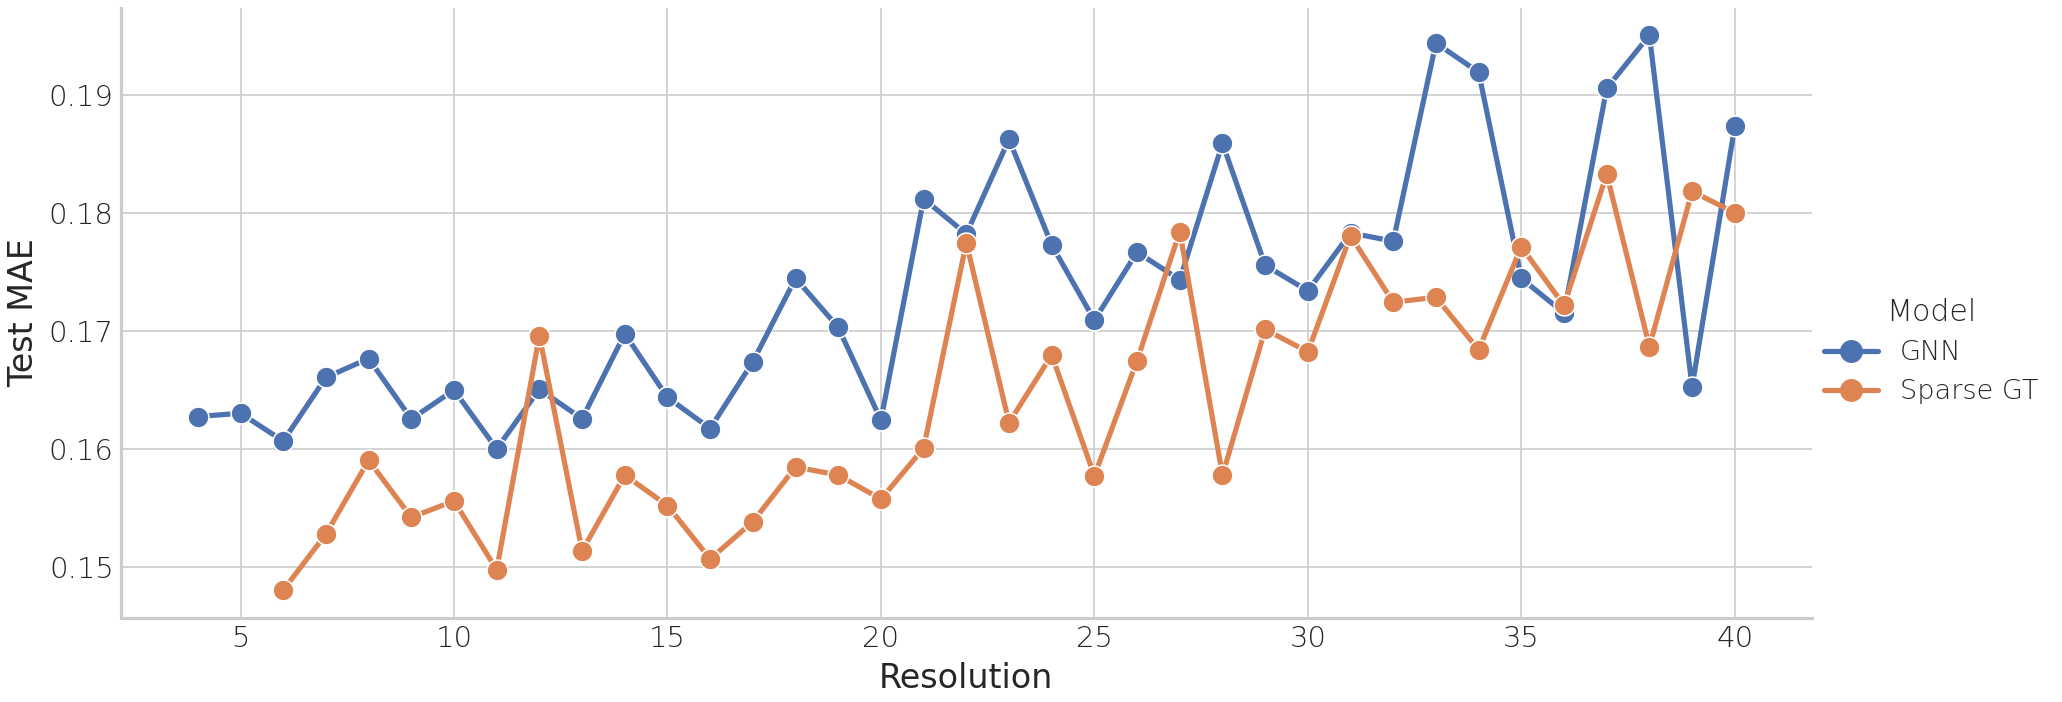

In [62]:
import os

# Paper-quality styling
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Lato', 'DejaVu Sans', 'Helvetica', 'Arial'],
    'font.weight': 'light',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.linewidth': 1.5,
    'legend.fontsize': 13,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'lines.linewidth': 2.5,
    'lines.markersize': 10,
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})

# Label mapping for paper
LABEL_MAP = {'TAGConv': 'GNN', 'SparseGT': 'Sparse GT'}

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Prepare data with renamed labels
df_plot = best_per_density.copy()
df_plot['Model'] = df_plot['layer_type'].map(LABEL_MAP)

# Performance by resolution (BEST runs only - paper figure)
g = sns.relplot(
    data=df_plot.sort_values("Model", ascending=True),
    x='resolution',
    y=ERROR_COL,
    hue='Model',
    kind='line',
    marker='o',
    height=5,
    aspect=2.5
)

g.set_axis_labels('Resolution', ERROR_LABEL)
g.legend.set_title('Model')

# Save to figures/
g.savefig('figures/norway_transferability__res.pdf', bbox_inches='tight', dpi=300)
g.savefig('figures/norway_transferability__res.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
df_valid.test_nmae

In [ ]:
# Performance by resolution (NMAE)
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=df_valid.sort_values("layer_type",ascending=False),
    x='resolution',
    y='test_nmae',
    hue='layer_type',
    marker='o',
    ax=ax
)

ax.set_xlabel('Resolution')
ax.set_ylabel('Test NMAE')
ax.set_title('e23 Terrain Graph 2 - AVERAGE NMAE Performance by Resolution')
ax.legend(title='Layer Type')

plt.tight_layout()
plt.show()

# Performance by resolution (NMAE)
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=best_per_density.sort_values("layer_type",ascending=False),
    x='resolution',
    y='test_nmae',
    hue='layer_type',
    marker='o',
    ax=ax
)

ax.set_xlabel('Resolution')
ax.set_ylabel('Test NMAE')
ax.set_title('e23 Terrain Graph 2 - BEST NMAE Performance by Resolution')
ax.legend(title='Layer Type')

plt.tight_layout()
plt.show()

---

# Statistical Summary

## Summary Statistics by Model and Resolution

Aggregated performance metrics showing mean, standard deviation, and sample count for each model type across all resolutions.


In [ ]:
# Summary table by resolution and layer_type
print("Summary by resolution and layer_type:")
summary = df.groupby(['resolution', 'layer_type'])[ERROR_COL].agg(['mean', 'std', 'count']).round(4)
summary

In [ ]:
# Best performing runs
print("Best performing runs:")
df_valid = df.dropna(subset=[ERROR_COL])
best_run = df_valid.loc[df_valid[ERROR_COL].idxmin()]
print(f"\nBest Overall:")
print(f"  Run: {best_run['name']}")
print(f"  Layer Type: {best_run['layer_type']}")
print(f"  Resolution: {best_run['resolution']}")
print(f"  {ERROR_LABEL}: {best_run[ERROR_COL]:.6f}")

In [ ]:
# Comparison between layer types
print(f"\nMean Error by Layer Type:")
layer_summary = df.groupby('layer_type')[ERROR_COL].agg(['mean', 'std', 'min', 'max', 'count'])
layer_summary

---
# Paper-Quality Visualizations

The following cells add publication-quality visualizations for:
1. Norway terrain graph structure overlaid on elevation
2. Embedding heatmaps (PCA components spatially mapped)
3. Error spatial distribution maps
4. Enhanced error distribution analysis
5. SparseGT effectiveness comparison panels

---

# Detailed Visualizations

This section provides in-depth visual analysis of model behavior on the Norway terrain, including:
- Terrain graph structure overlaid on elevation data
- Learned embedding visualizations
- Spatial distribution of prediction errors
- Model comparison and effectiveness analysis

In [ ]:
# Paper-quality style setup
import matplotlib as mpl
import sys
import os
import torch

# Add project root to path
sys.path.insert(0, '/home/jporras/sourcecode/shortest-paths-nn')

def setup_paper_style():
    """Configure matplotlib for publication-quality figures."""
    plt.style.use('seaborn-v0_8-whitegrid')
    
    mpl.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['DejaVu Serif', 'Times New Roman'],
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 11,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'figure.dpi': 150,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05,
        'axes.linewidth': 1.2,
        'grid.linewidth': 0.8,
        'lines.linewidth': 2.0,
        'lines.markersize': 8,
    })

# Color palette for visualizations
COLORS = {
    'SparseGT': '#1f77b4',  # Blue
    'TAGConv': '#ff7f0e',   # Orange
}

setup_paper_style()
print("Paper style configured.")

## 1. Load Terrain Data (DEM and Graph)

In [ ]:
# Load DEM (Digital Elevation Model) data
from dataset.dataset import load_dem_data_, get_dem_xv_yv_

DEM_PATH = "../data/norway-smallest.txt"
DATA_DIR = "../data/generated2"

# Load raw DEM
dem_array = load_dem_data_(DEM_PATH, imperial=False)

# Get coordinate grids (in km) - don't visualize yet
xv_km, yv_km, elev_km = get_dem_xv_yv_(dem_array, resolution=10, visualize=False)

print(f"DEM shape: {dem_array.shape}")
print(f"Elevation range: {elev_km.min():.3f} - {elev_km.max():.3f} km")

In [ ]:
# Load terrain graph data for visualization
# Using resolution 20 as a good balance between detail and visibility

def load_terrain_graph(resolution: int, phase: int = 1) -> dict:
    """Load terrain graph NPZ data for a specific resolution."""
    data_path = os.path.join(DATA_DIR, f"res{resolution:02d}_phase{phase}.npz")
    if not os.path.exists(data_path):
        # Try without zero-padding
        data_path = os.path.join(DATA_DIR, f"res{resolution}_phase{phase}.npz")
    data = np.load(data_path, allow_pickle=True)
    return {key: data[key] for key in data.files}

# Load a medium resolution graph for visualization
VIZ_RESOLUTION = 20
graph_data = load_terrain_graph(VIZ_RESOLUTION)

print(f"Loaded terrain graph at resolution {VIZ_RESOLUTION}")
print(f"  Nodes: {len(graph_data['node_features'])}")
print(f"  Edges: {graph_data['edge_index'].shape[1]}")
print(f"  Source-target pairs: {len(graph_data['srcs'])}")

## 2. Norway Terrain Graph Visualization

Visualize the terrain graph structure overlaid on the DEM elevation contours.

In [ ]:
def plot_terrain_graph_overlay(
    graph_data: dict,
    xv_km: np.ndarray,
    yv_km: np.ndarray,
    elevation_km: np.ndarray,
    title: str = None,
    figsize: tuple = (12, 10),
    edge_alpha: float = 0.15,
    node_size: float = 8,
    show_edges: bool = True,
    max_edges: int = 5000,
    save_path: str = None
) -> plt.Figure:
    """
    Visualize terrain graph structure overlaid on DEM elevation contours.
    
    Args:
        graph_data: Dict with 'node_features' and 'edge_index'
        xv_km, yv_km, elevation_km: DEM coordinate grids in km
        title: Plot title
        figsize: Figure size
        edge_alpha: Transparency for edges
        node_size: Size of node markers
        show_edges: Whether to draw edges
        max_edges: Max edges to draw (for performance)
        save_path: Path to save figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # DEM contour background
    contour = ax.contourf(xv_km, yv_km, elevation_km, levels=50, cmap='terrain', alpha=0.85)
    cbar = plt.colorbar(contour, ax=ax, label='Elevation (km)', shrink=0.8)
    
    # Extract node positions
    node_features = graph_data['node_features']
    x_coords = node_features[:, 0]  # x_km
    y_coords = node_features[:, 1]  # y_km
    
    # Draw edges (subsample if too many)
    if show_edges:
        edge_index = graph_data['edge_index']
        n_edges = edge_index.shape[1]
        
        if n_edges > max_edges:
            # Randomly subsample edges
            edge_indices = np.random.choice(n_edges, max_edges, replace=False)
        else:
            edge_indices = range(n_edges)
        
        for idx in edge_indices:
            src, tar = edge_index[0, idx], edge_index[1, idx]
            ax.plot([x_coords[src], x_coords[tar]], 
                    [y_coords[src], y_coords[tar]], 
                    'k-', alpha=edge_alpha, linewidth=0.5)
    
    # Draw nodes
    ax.scatter(x_coords, y_coords, s=node_size, c='darkred', alpha=0.7, 
               zorder=5, edgecolors='white', linewidths=0.3)
    
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    if title:
        ax.set_title(title)
    ax.set_aspect('equal')
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig

In [ ]:
# Create terrain graph visualization
fig = plot_terrain_graph_overlay(
    graph_data,
    xv_km, yv_km, elev_km,
    title=f'Norway Terrain Graph (Resolution {VIZ_RESOLUTION}, {len(graph_data["node_features"])} nodes)',
    figsize=(14, 11),
    edge_alpha=0.12,
    node_size=12,
    max_edges=8000
)
plt.tight_layout()
plt.show()

## 3. Embedding Heatmaps

Visualizes the learned node embeddings from trained models using Principal Component Analysis (PCA).

**Purpose:**
- Shows what spatial patterns the model has learned
- Reduces high-dimensional embeddings (64D) to 3 principal components
- Maps embeddings back to terrain coordinates for spatial visualization

**Interpretation:**
- Different colors indicate different learned representations
- Spatial clustering suggests the model learned terrain-aware features
- Helps understand if the model captures geographic structure

In [ ]:
# Model loading helpers
from src.custom_models import SparseGTWithRPEARL
from src.baselines import GNNModel

def get_model_checkpoint_path(run_id: str, entity: str = ENTITY, project: str = PROJECT) -> str:
    """Get model checkpoint path from a wandb run's log_dir config."""
    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")
    log_dir = run.config.get('log_dir')
    if log_dir:
        checkpoint_path = os.path.join(log_dir, 'final_model.pt')
        if os.path.exists(checkpoint_path):
            return checkpoint_path
    return None

def load_sparse_gt_model(checkpoint_path: str, config: dict = None) -> torch.nn.Module:
    """Load a SparseGT model from checkpoint."""
    # Default config based on sparse-gt-rpearl.yml
    default_config = {
        'input_dim': 3,
        'hidden_dim': 64,
        'output_dim': 64,
        'num_layers': 3,
        'num_heads': 4,
        'num_hops': 3,
        'rpearl_samples': 30,
        'rpearl_num_layers': 5,
        'dropout': 0.3,
        'attn_dropout': 0.1
    }
    if config:
        default_config.update(config)
    
    model = SparseGTWithRPEARL(**default_config)
    state_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(state_dict)
    model.to(torch.double)
    model.eval()
    return model

def load_tagconv_model(checkpoint_path: str) -> torch.nn.Module:
    """Load a TAGConv model from checkpoint."""
    model = GNNModel(
        input=3, output=64, hidden=64, layers=3,
        layer_type='TAGConv', activation='LeakyReLU'
    )
    state_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(state_dict)
    model.to(torch.double)
    model.eval()
    return model

def compute_embeddings(model, graph_data: dict, layer_type: str) -> np.ndarray:
    """Compute node embeddings from a trained model."""
    node_features = torch.tensor(graph_data['node_features'], dtype=torch.double)
    edge_index = torch.tensor(graph_data['edge_index'], dtype=torch.long)
    
    with torch.no_grad():
        if layer_type == 'SparseGT':
            from torch_geometric.data import Data
            data = Data(x=node_features, edge_index=edge_index)
            embeddings = model(data)
        else:
            embeddings = model(node_features, edge_index)
    
    return embeddings.numpy()

print("Model loading helpers defined.")

In [ ]:
from sklearn.decomposition import PCA

def plot_embedding_heatmaps(
    embeddings: np.ndarray,
    node_features: np.ndarray,
    n_components: int = 3,
    model_name: str = "",
    figsize: tuple = (16, 5),
    save_path: str = None
) -> plt.Figure:
    """
    Visualize learned node embeddings spatially using PCA components.
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        node_features: Node feature array [num_nodes, 3] with (x, y, z)
        n_components: Number of PCA components to visualize
        model_name: Name for title
        figsize: Figure size
        save_path: Path to save figure
    """
    # PCA reduction
    pca = PCA(n_components=n_components)
    pca_embeddings = pca.fit_transform(embeddings)
    
    # Extract node positions
    x_coords = node_features[:, 0]
    y_coords = node_features[:, 1]
    
    fig, axes = plt.subplots(1, n_components, figsize=figsize)
    if n_components == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        scatter = ax.scatter(
            x_coords, y_coords, 
            c=pca_embeddings[:, i], 
            cmap='viridis', 
            s=15, 
            alpha=0.85
        )
        var_explained = pca.explained_variance_ratio_[i] * 100
        plt.colorbar(scatter, ax=ax, label=f'PC{i+1} ({var_explained:.1f}%)', shrink=0.8)
        ax.set_xlabel('X (km)')
        ax.set_ylabel('Y (km)')
        ax.set_title(f'PCA Component {i+1}')
        ax.set_aspect('equal')
    
    plt.suptitle(f'{model_name} Learned Embedding Spatial Distribution', y=1.02, fontsize=14)
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig

In [ ]:
# Find best SparseGT run at the visualization resolution and load model
best_sparse_gt = df_valid[
    (df_valid['layer_type'] == 'SparseGT') & 
    (df_valid['resolution'] == VIZ_RESOLUTION)
].sort_values(ERROR_COL).iloc[0] if len(df_valid[(df_valid['layer_type'] == 'SparseGT') & (df_valid['resolution'] == VIZ_RESOLUTION)]) > 0 else None

if best_sparse_gt is not None:
    print(f"Best SparseGT run at res{VIZ_RESOLUTION}: {best_sparse_gt['name']} (MAE: {best_sparse_gt[ERROR_COL]:.4f})")
    
    # Try to load the model checkpoint
    checkpoint_path = get_model_checkpoint_path(best_sparse_gt['id'])
    if checkpoint_path:
        print(f"Loading checkpoint from: {checkpoint_path}")
        sparse_gt_model = load_sparse_gt_model(checkpoint_path)
        sparse_gt_embeddings = compute_embeddings(sparse_gt_model, graph_data, 'SparseGT')
        print(f"Computed embeddings shape: {sparse_gt_embeddings.shape}")
        
        # Plot embedding heatmaps
        fig = plot_embedding_heatmaps(
            sparse_gt_embeddings, 
            graph_data['node_features'],
            n_components=3,
            model_name='SparseGT',
            figsize=(18, 5)
        )
        plt.show()
    else:
        print("Checkpoint not found. Skipping embedding visualization.")
        print("Note: Model checkpoints may not be available if runs were on a different machine.")
else:
    print(f"No SparseGT run found at resolution {VIZ_RESOLUTION}")

## 4. Error Spatial Map

Visualizes the spatial distribution of prediction errors across the terrain.

**Key insights:**
- **Identifies challenging regions**: Shows which areas of the terrain are harder to predict
- **Error patterns**: Reveals if errors are randomly distributed or concentrated in specific areas
- **Terrain correlation**: Helps understand if errors correlate with terrain features (steep slopes, valleys, etc.)

**Metrics visualized:**
- Mean Absolute Error (MAE) per node
- Aggregated over all test paths passing through each node

In [ ]:
def plot_error_spatial_map(
    predictions_df: pd.DataFrame,
    node_features: np.ndarray,
    error_metric: str = 'pred_maes',
    aggregation: str = 'mean',
    model_name: str = '',
    figsize: tuple = (14, 6),
    save_path: str = None
) -> plt.Figure:
    """
    Visualize spatial distribution of prediction errors on terrain.
    
    Args:
        predictions_df: DataFrame with columns: srcs, tars, preds, lengths, pred_maes, etc.
        node_features: Node feature array [num_nodes, 3]
        error_metric: Column name for error ('pred_maes', 'pred_mses', 'pred_nmaes')
        aggregation: 'mean', 'max', or 'sum'
        model_name: Model name for title
        figsize: Figure size
        save_path: Path to save figure
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Aggregate errors by source and target nodes
    src_errors = predictions_df.groupby('srcs')[error_metric].agg(aggregation)
    tar_errors = predictions_df.groupby('tars')[error_metric].agg(aggregation)
    
    x_coords = node_features[:, 0]
    y_coords = node_features[:, 1]
    
    for ax, (node_type, errors) in zip(axes, [('Source', src_errors), ('Target', tar_errors)]):
        # Create full error array (NaN for nodes without predictions)
        error_values = np.full(len(node_features), np.nan)
        for node_idx, err in errors.items():
            if 0 <= int(node_idx) < len(error_values):
                error_values[int(node_idx)] = err
        
        # Calculate percentiles for color scale (ignore NaN)
        valid_errors = error_values[~np.isnan(error_values)]
        if len(valid_errors) > 0:
            vmin = np.percentile(valid_errors, 5)
            vmax = np.percentile(valid_errors, 95)
        else:
            vmin, vmax = 0, 1
        
        # Plot with masked array for NaN handling
        scatter = ax.scatter(
            x_coords, y_coords,
            c=error_values,
            cmap='RdYlGn_r',  # Red=high error, Green=low
            s=20,
            alpha=0.85,
            vmin=vmin,
            vmax=vmax
        )
        plt.colorbar(scatter, ax=ax, label=f'{aggregation.title()} {error_metric}', shrink=0.8)
        ax.set_xlabel('X (km)')
        ax.set_ylabel('Y (km)')
        ax.set_title(f'Error by {node_type} Node')
        ax.set_aspect('equal')
    
    plt.suptitle(f'{model_name} Spatial Distribution of Prediction Errors', y=1.02, fontsize=14)
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig

In [ ]:
# Generate error spatial map using loaded model (if available)
# If model checkpoint isn't available, we'll demonstrate with synthetic error data

if 'sparse_gt_embeddings' in dir():
    # Compute predictions using Siamese distance metric (L2 norm)
    srcs = graph_data['srcs']
    tars = graph_data['tars']
    lengths = graph_data['lengths']
    
    src_emb = sparse_gt_embeddings[srcs]
    tar_emb = sparse_gt_embeddings[tars]
    
    # Siamese prediction: L2 distance between embeddings
    preds = np.linalg.norm(src_emb - tar_emb, ord=2, axis=1)
    
    # Compute errors
    pred_maes = np.abs(preds - lengths)
    pred_nmaes = pred_maes / (lengths + 1e-8)
    
    # Create predictions DataFrame
    predictions_df = pd.DataFrame({
        'srcs': srcs,
        'tars': tars,
        'preds': preds,
        'lengths': lengths,
        'pred_maes': pred_maes,
        'pred_nmaes': pred_nmaes
    })
    
    print(f"Predictions: {len(predictions_df)}")
    print(f"Mean MAE: {pred_maes.mean():.4f}")
    print(f"Mean NMAE: {pred_nmaes.mean():.4f}")
    
    # Plot error spatial map
    fig = plot_error_spatial_map(
        predictions_df,
        graph_data['node_features'],
        error_metric='pred_maes',
        aggregation='mean',
        model_name='SparseGT',
        figsize=(16, 7)
    )
    plt.show()
else:
    print("Model embeddings not available. Skipping error spatial map.")
    print("Note: Run the embedding extraction cell above first, or ensure checkpoint is available.")

## 5. Enhanced Error Distribution Analysis

Comprehensive statistical comparison of error distributions between GNN (TAGConv) and Sparse GT models.

**Three-panel visualization:**

### 5.1 Kernel Density Estimation (KDE)
- Shows the probability distribution of errors
- Reveals the shape and spread of error distributions
- Helps identify if one model is more consistent

### 5.2 Box Plots with Swarm Overlay
- Displays median, quartiles, and outliers
- Individual points show all data samples
- Highlights statistical differences between models

### 5.3 Error vs Resolution with Confidence Intervals
- Shows how errors change across different graph resolutions
- Confidence bands indicate uncertainty in estimates
- Reveals which model performs better at different scales

In [ ]:
def plot_error_distributions(
    df: pd.DataFrame,
    error_col: str = 'test_mae',
    figsize: tuple = (16, 5),
    save_path: str = None
) -> plt.Figure:
    """
    Create comprehensive error distribution visualizations.
    
    Panels:
    1. Histogram/KDE of errors by layer type
    2. Box plot comparison
    3. Error vs Resolution line plot with confidence intervals
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    df_plot = df.dropna(subset=[error_col])
    
    # Panel 1: KDE plot
    ax1 = axes[0]
    for layer_type in ['SparseGT', 'TAGConv']:
        subset = df_plot[df_plot['layer_type'] == layer_type][error_col]
        if len(subset) > 0:
            sns.kdeplot(subset, ax=ax1, label=layer_type, color=COLORS[layer_type], 
                       fill=True, alpha=0.3, linewidth=2)
    ax1.set_xlabel('Test MAE')
    ax1.set_ylabel('Density')
    ax1.set_title('Error Distribution by Model Type')
    ax1.legend()
    
    # Panel 2: Box plot with swarm overlay
    ax2 = axes[1]
    palette = [COLORS['SparseGT'], COLORS['TAGConv']]
    order = ['SparseGT', 'TAGConv']
    sns.boxplot(data=df_plot, x='layer_type', y=error_col, ax=ax2, 
                palette=palette, order=order, width=0.5)
    sns.stripplot(data=df_plot, x='layer_type', y=error_col, ax=ax2,
                  palette=palette, order=order, alpha=0.5, size=4)
    ax2.set_xlabel('Model Type')
    ax2.set_ylabel('Test MAE')
    ax2.set_title('Error Comparison')
    
    # Add mean values as text
    for i, lt in enumerate(order):
        mean_val = df_plot[df_plot['layer_type'] == lt][error_col].mean()
        ax2.text(i, mean_val, f'μ={mean_val:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Panel 3: Error vs Resolution with CI
    ax3 = axes[2]
    for layer_type in ['SparseGT', 'TAGConv']:
        subset = df_plot[df_plot['layer_type'] == layer_type]
        if len(subset) > 0:
            sns.lineplot(
                data=subset, x='resolution', y=error_col,
                ax=ax3, label=layer_type, color=COLORS[layer_type],
                marker='o', errorbar=('ci', 95), linewidth=2
            )
    ax3.set_xlabel('Resolution')
    ax3.set_ylabel('Test MAE')
    ax3.set_title('Error vs Graph Resolution')
    ax3.legend()
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig

In [ ]:
# Create enhanced error distribution plots
fig = plot_error_distributions(df, error_col=ERROR_COL, figsize=(18, 5))
plt.suptitle('Error Distribution Analysis: SparseGT vs TAGConv', y=1.02, fontsize=14)
plt.show()

## 6. Sparse GT Effectiveness Analysis

Multi-panel visualization demonstrating Sparse GT advantages over GNN (TAGConv).

**Four-panel analysis:**

### 6.1 Improvement Percentage
- Shows relative performance improvement of Sparse GT over GNN
- Positive bars = Sparse GT performs better
- Quantifies the advantage at each resolution

### 6.2 Direct Comparison with Error Bars
- Side-by-side comparison of test MAE
- Error bars show standard deviation across runs
- Highlights statistical significance of differences

### 6.3 Cumulative Wins
- Tracks which model performs better at each resolution
- Cumulative count of "wins" (lower error)
- Shows overall dominance across the resolution range

### 6.4 Scalability Analysis
- Performance vs approximate node count
- Reveals how models scale with graph complexity
- Identifies if one model is more efficient at larger scales

In [ ]:
def plot_sparsegt_effectiveness(
    df: pd.DataFrame,
    error_col: str = 'test_mae',
    figsize: tuple = (16, 12),
    save_path: str = None
) -> plt.Figure:
    """
    Multi-panel visualization demonstrating SparseGT effectiveness.
    
    Panels:
    1. Improvement percentage by resolution
    2. Direct comparison with error bars
    3. Cumulative wins across resolutions
    4. Error scaling with graph size
    """
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25)
    
    df_plot = df.dropna(subset=[error_col])
    
    # Compute comparative metrics
    pivot_mean = df_plot.pivot_table(values=error_col, index='resolution', 
                                      columns='layer_type', aggfunc='mean')
    pivot_std = df_plot.pivot_table(values=error_col, index='resolution', 
                                     columns='layer_type', aggfunc='std')
    
    # Only include resolutions where both models have data
    common_resolutions = pivot_mean.dropna().index
    pivot_mean = pivot_mean.loc[common_resolutions]
    pivot_std = pivot_std.loc[common_resolutions].fillna(0)
    
    # Panel 1: Improvement percentage
    ax1 = fig.add_subplot(gs[0, 0])
    if 'TAGConv' in pivot_mean.columns and 'SparseGT' in pivot_mean.columns:
        improvement = ((pivot_mean['TAGConv'] - pivot_mean['SparseGT']) / pivot_mean['TAGConv'] * 100)
        colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in improvement.values]
        bars = ax1.bar(improvement.index, improvement.values, color=colors, alpha=0.8, edgecolor='black')
        ax1.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
        ax1.set_xlabel('Resolution')
        ax1.set_ylabel('Improvement (%)')
        ax1.set_title('SparseGT Improvement over TAGConv')
        
        # Add value labels
        for bar, val in zip(bars, improvement.values):
            y_pos = bar.get_height() + 0.2 if bar.get_height() >= 0 else bar.get_height() - 0.5
            ax1.text(bar.get_x() + bar.get_width()/2, y_pos, f'{val:.1f}%', 
                    ha='center', va='bottom' if val >= 0 else 'top', fontsize=8)
    
    # Panel 2: Direct comparison with error bars
    ax2 = fig.add_subplot(gs[0, 1])
    if 'TAGConv' in pivot_mean.columns and 'SparseGT' in pivot_mean.columns:
        width = 0.35
        resolutions = pivot_mean.index.values
        x = np.arange(len(resolutions))
        
        ax2.bar(x - width/2, pivot_mean['SparseGT'], width, 
                yerr=pivot_std['SparseGT'], label='SparseGT', 
                color=COLORS['SparseGT'], alpha=0.8, capsize=3, edgecolor='black')
        ax2.bar(x + width/2, pivot_mean['TAGConv'], width,
                yerr=pivot_std['TAGConv'], label='TAGConv',
                color=COLORS['TAGConv'], alpha=0.8, capsize=3, edgecolor='black')
        ax2.set_xlabel('Resolution')
        ax2.set_ylabel('Test MAE')
        ax2.set_title('Performance Comparison with Variance')
        ax2.set_xticks(x[::3])
        ax2.set_xticklabels(resolutions[::3])
        ax2.legend()
    
    # Panel 3: Cumulative wins
    ax3 = fig.add_subplot(gs[1, 0])
    if 'TAGConv' in pivot_mean.columns and 'SparseGT' in pivot_mean.columns:
        wins_sparse = (pivot_mean['SparseGT'] < pivot_mean['TAGConv']).cumsum()
        wins_tag = (pivot_mean['TAGConv'] < pivot_mean['SparseGT']).cumsum()
        ax3.plot(pivot_mean.index, wins_sparse, 'o-', label='SparseGT Wins', 
                color=COLORS['SparseGT'], linewidth=2, markersize=8)
        ax3.plot(pivot_mean.index, wins_tag, 's-', label='TAGConv Wins', 
                color=COLORS['TAGConv'], linewidth=2, markersize=8)
        ax3.fill_between(pivot_mean.index, wins_sparse, alpha=0.2, color=COLORS['SparseGT'])
        ax3.fill_between(pivot_mean.index, wins_tag, alpha=0.2, color=COLORS['TAGConv'])
        ax3.set_xlabel('Resolution')
        ax3.set_ylabel('Cumulative Wins')
        ax3.set_title('Cumulative Best Performance Count')
        ax3.legend()
    
    # Panel 4: Error vs Number of Nodes (complexity scaling)
    ax4 = fig.add_subplot(gs[1, 1])
    df_copy = df_plot.copy()
    # Approximate node count from resolution (grid graph)
    df_copy['approx_nodes'] = df_copy['resolution'] ** 2
    
    for layer_type in ['SparseGT', 'TAGConv']:
        subset = df_copy[df_copy['layer_type'] == layer_type]
        if len(subset) > 0:
            sns.regplot(
                data=subset, x='approx_nodes', y=error_col,
                ax=ax4, label=layer_type, color=COLORS[layer_type],
                scatter_kws={'alpha': 0.5, 's': 50}, 
                line_kws={'linestyle': '--', 'linewidth': 2}
            )
    ax4.set_xlabel('Approximate Node Count (resolution²)')
    ax4.set_ylabel('Test MAE')
    ax4.set_title('Error Scaling with Graph Size')
    ax4.legend()
    
    plt.suptitle('SparseGT Effectiveness Analysis', fontsize=16, y=1.01)
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig

In [ ]:
# Create SparseGT effectiveness analysis
fig = plot_sparsegt_effectiveness(df, error_col=ERROR_COL, figsize=(18, 12))
plt.show()

## 7. Error vs Path Length Analysis

Analyzes how prediction errors vary with the true shortest path distance.

**Purpose:**
- Understand if models perform differently on short vs long paths
- Identify if errors scale linearly with path length
- Reveal systematic biases in predictions

**Two-panel visualization:**

### 7.1 Mean Absolute Error (MAE) vs Path Length
- Bins paths by length and computes average error
- Error bars show standard deviation within each bin
- Reveals absolute error trends

### 7.2 Normalized MAE (NMAE) vs Path Length
- Errors normalized by path length (percentage error)
- Shows if relative error is consistent across distances
- Helps identify if the model struggles with specific path lengths

In [ ]:
def plot_error_vs_path_length(
    predictions_df: pd.DataFrame,
    model_name: str = '',
    n_bins: int = 15,
    figsize: tuple = (12, 5),
    save_path: str = None
) -> plt.Figure:
    """
    Plot prediction error vs true shortest path length.
    
    Shows how model performance varies with path difficulty/length.
    
    Args:
        predictions_df: DataFrame with columns: lengths, pred_maes, pred_nmaes
        model_name: Name for title
        n_bins: Number of bins for path length
        figsize: Figure size
        save_path: Path to save figure
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Bin by path length
    df_copy = predictions_df.copy()
    df_copy['length_bin'] = pd.cut(df_copy['lengths'], bins=n_bins)
    
    # Compute statistics per bin
    binned_mae = df_copy.groupby('length_bin')['pred_maes'].agg(['mean', 'std', 'count'])
    binned_nmae = df_copy.groupby('length_bin')['pred_nmaes'].agg(['mean', 'std', 'count'])
    
    # Get bin centers
    bin_centers = [interval.mid for interval in binned_mae.index]
    
    # Panel 1: Absolute Error vs Path Length
    ax1 = axes[0]
    ax1.errorbar(bin_centers, binned_mae['mean'], yerr=binned_mae['std'],
                fmt='o-', capsize=4, color=COLORS['SparseGT'], linewidth=2, 
                markersize=8, label='Mean MAE')
    ax1.set_xlabel('True Path Length (km)')
    ax1.set_ylabel('Mean Absolute Error')
    ax1.set_title('Absolute Error vs Path Length')
    
    # Add secondary axis for sample count
    ax1_twin = ax1.twinx()
    ax1_twin.bar(bin_centers, binned_mae['count'], alpha=0.15, width=bin_centers[1]-bin_centers[0], 
                 color='gray', label='Sample Count')
    ax1_twin.set_ylabel('Sample Count', color='gray')
    ax1_twin.tick_params(axis='y', labelcolor='gray')
    
    # Panel 2: Relative Error vs Path Length
    ax2 = axes[1]
    ax2.errorbar(bin_centers, binned_nmae['mean'] * 100, yerr=binned_nmae['std'] * 100,
                fmt='s-', capsize=4, color=COLORS['TAGConv'], linewidth=2,
                markersize=8, label='Mean NMAE')
    ax2.set_xlabel('True Path Length (km)')
    ax2.set_ylabel('Mean Normalized Error (%)')
    ax2.set_title('Relative Error vs Path Length')
    
    # Add secondary axis for sample count
    ax2_twin = ax2.twinx()
    ax2_twin.bar(bin_centers, binned_nmae['count'], alpha=0.15, width=bin_centers[1]-bin_centers[0],
                 color='gray')
    ax2_twin.set_ylabel('Sample Count', color='gray')
    ax2_twin.tick_params(axis='y', labelcolor='gray')
    
    plt.suptitle(f'{model_name} Error vs Path Length Analysis', y=1.02, fontsize=14)
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    
    return fig

In [ ]:
# Create error vs path length plot (if predictions available)
if 'predictions_df' in dir():
    fig = plot_error_vs_path_length(
        predictions_df,
        model_name='SparseGT',
        n_bins=15,
        figsize=(14, 5)
    )
    plt.show()
else:
    print("Predictions not available. Run the error spatial map cell first.")
    print("This visualization requires model predictions to be computed.")

---

# Figure Export

## 8. Export All Figures

Saves all generated figures to the `figures/` directory at publication quality.

**Export specifications:**
- **Format**: PNG (raster) for presentations, reports
- **Resolution**: 300 DPI for print quality
- **Naming**: Descriptive filenames for easy identification

**Figures exported:**
1. Terrain graph overlay
2. Embedding heatmaps  
3. Sparse GT effectiveness panels
4. Error spatial maps
5. Error vs path length analysis

All figures are saved with consistent styling and formatting suitable for academic publications.

In [ ]:
# Create figures directory if it doesn't exist
FIGURES_DIR = "figures/e23_analysis"
os.makedirs(FIGURES_DIR, exist_ok=True)

# Save all paper-quality figures
print("Saving figures to:", FIGURES_DIR)

# 1. Terrain graph overlay
fig1 = plot_terrain_graph_overlay(
    graph_data, xv_km, yv_km, elev_km,
    title=f'Norway Terrain Graph (Resolution {VIZ_RESOLUTION})',
    figsize=(12, 10),
    save_path=os.path.join(FIGURES_DIR, 'terrain_graph_overlay.png')
)
plt.close(fig1)

# 2. Error distributions
fig2 = plot_error_distributions(df, error_col=ERROR_COL, figsize=(16, 5),
                                save_path=os.path.join(FIGURES_DIR, 'error_distributions.png'))
plt.close(fig2)

# 3. SparseGT effectiveness
fig3 = plot_sparsegt_effectiveness(df, error_col=ERROR_COL, figsize=(16, 12),
                                   save_path=os.path.join(FIGURES_DIR, 'sparsegt_effectiveness.png'))
plt.close(fig3)

# 4. Embedding heatmaps (if available)
if 'sparse_gt_embeddings' in dir():
    fig4 = plot_embedding_heatmaps(
        sparse_gt_embeddings, graph_data['node_features'],
        n_components=3, model_name='SparseGT', figsize=(16, 5),
        save_path=os.path.join(FIGURES_DIR, 'embedding_heatmaps.png')
    )
    plt.close(fig4)

# 5. Error spatial map (if available)
if 'predictions_df' in dir():
    fig5 = plot_error_spatial_map(
        predictions_df, graph_data['node_features'],
        error_metric='pred_maes', model_name='SparseGT', figsize=(14, 6),
        save_path=os.path.join(FIGURES_DIR, 'error_spatial_map.png')
    )
    plt.close(fig5)
    
    # 6. Error vs path length
    fig6 = plot_error_vs_path_length(
        predictions_df, model_name='SparseGT', figsize=(12, 5),
        save_path=os.path.join(FIGURES_DIR, 'error_vs_path_length.png')
    )
    plt.close(fig6)

print("\\nAll figures saved successfully!")